In [1]:
# load std libs
from os import scandir

# load third-party libraries
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# load source code
from src.image_loader import load_images
from src.utils import one_hot, shuffle_and_split

# initialization code
np.random.seed(42)
IMG_SIZE = 224

### Resize images
Run this once to resize the images and save to disk. Make sure you've downloaded the training data, unzipped it, and placed it in the `./data/train/raw` directory. This takes a few minutes.

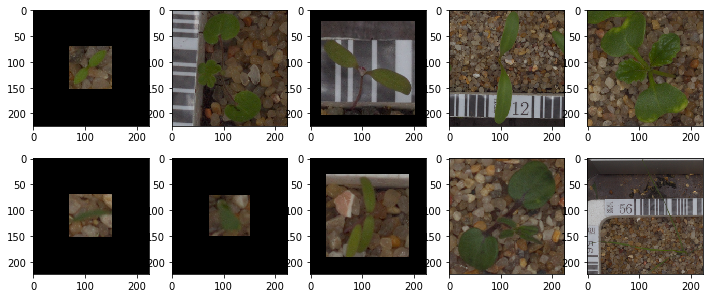

In [2]:
train_imgs = load_images("./data/train/raw/*/*.png",
                         desired_size=IMG_SIZE,
                         scale_down=True,
                         pad_up=True,
                         write_to="./data/train/resized",
                         preserve_dir_tree_at="./data/train/raw")

fig = plt.figure(figsize=(12, 5))
for i in range(10):
    sub = fig.add_subplot(2, 5, i + 1)
    rand_i = np.random.randint(0, len(train_imgs))
    sub.imshow(train_imgs[rand_i])

del train_imgs

In [3]:
class_names = [f.name for f in scandir("./data/train/raw") if f.is_dir()]
print(class_names)

class_name_to_idx = {}
class_idx_to_name = {}
train_imgs_ord = []
train_labels_ord = []

for i, name in enumerate(class_names):
    class_name_to_idx[name] = i
    class_idx_to_name[i] = name
    imgs = load_images("./data/train/resized/%s/*.png" % name, desired_size=IMG_SIZE, scale_down=True, pad_up=True)
    train_imgs_ord.extend(imgs)
    train_labels_ord.extend([i] * len(imgs))

train_imgs_ord = np.array(train_imgs_ord)
print(train_imgs_ord.shape)
train_labels_ord = one_hot(train_labels_ord)
print(train_labels_ord.shape)

['Cleavers', 'Sugar beet', 'Common Chickweed', 'Loose Silky-bent', 'Scentless Mayweed', 'Shepherds Purse', 'Fat Hen', 'Common wheat', 'Black-grass', 'Small-flowered Cranesbill', 'Charlock', 'Maize']
(4750, 224, 224, 3)
(4750, 12)


In [4]:
train_data, train_labels, dev_data, dev_labels = shuffle_and_split(train_imgs_ord, train_labels_ord, dev_fraction=0.15)
print(train_data.shape)
print(train_labels.shape)
print(dev_data.shape)
print(dev_labels.shape)

(4038, 224, 224, 3)
(4038, 12)
(712, 224, 224, 3)
(712, 12)
